In [228]:
import cv2
import numpy as np
import numpy.linalg as lin
import math
from PIL import Image
import matplotlib
from matplotlib import pyplot as plt

In [229]:
distThresh=30
divisor=1

## Matched KeyPoint

In [230]:
def MatchedKeyPoint(img1, img2):

    # Initiate ORB detector
    orb = cv2.ORB_create()
    
    kp1, des1 = orb.detectAndCompute(img1,None)
    kp2, des2 = orb.detectAndCompute(img2,None) 

    ## bf matchi g with norm hamming
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x:x.distance)
    
    ## filter some matches with far difference
    for item in matches:
        if item.distance>distThresh:
            matches.remove(item)
    
    ## return pairs
    Left=[]
    Right=[]
    for idx in range(len(matches)):
        Left.append(kp1[matches[idx].queryIdx].pt)
        Right.append(kp2[matches[idx].queryIdx].pt)

    return Left, Right

## Hessian Function

In [231]:
def make_Hessian_all(a1,b1,c1,a2,b2,c2,p,q, Left,Right):
    H=np.array([[0.0 for _ in range(8)] for __ in range(8)])
    for i in range(8):
        for j in range(8):
            H[i][j]=sums(i,j,a1,b1,c1,a2,b2,c2,p,q,Left,Right)
    return H

def make_Hessians(a1,b1,c1, a2,b2,c2, p,q, Left,Right):
    H_x=np.array([[0.0 for _ in range(5)] for __ in range(5)])
    H_y=np.array([[0.0 for _ in range(5)] for __ in range(5)])
    for i in range(5):
        for j in range(5):
            H_x[i][j]=sums(i,j,a1,b1,c1,p,q,Left,Right)
            H_y[i][j]=sums(i,j,a2,b2,c2,p,q,Left,Right)
    return H_x, H_y

In [232]:
_p(1,2,3,4,5,6,7,"Yes",1,2)

-1.5

In [233]:
def f(p,q,x,y):
    return p*x+q*y+1
def g(a,b,c,x,y):
    return a*x+b*y+c

def _p(a,b,c,p,q,x,y, use_value=None, rf=0,rg=0):
    global f,g
    if not use_value:
        rf=f(p,q,x,y)
        rg=g(a,b,c,x,y)
    return -x*rf/rg/rg
            
def _q(a,b,c,p,q,x,y, use_value=None, rf=0,rg=0):
    global f,g
    if not use_value:
        rf=f(p,q,x,y)
        rg=g(a,b,c,x,y)    
    return -y*rf/rg/rg

def _a(a,b,c,p,q,x,y, use_value=None, rf=0,rg=0):
    global f,g
    if not use_value:
        rf=f(p,q,x,y)
        rg=g(a,b,c,x,y)
    return x/rg

def _b(a,b,c,p,q,x,y, use_value=None, rf=0,rg=0):
    global f,g
    if not use_value:
        rf=f(p,q,x,y)
        rg=g(a,b,c,x,y)
    return y/rg

def _c(a,b,c,p,q,x,y, use_value=None, rf=0,rg=0):
    global f,g
    if not use_value:
        rf=f(p,q,x,y)
        rg=g(a,b,c,x,y)    
    return 1/rg

funcs_all=[_a,_b,_c,_a,_b,_c,_p,_q]
funcs=[_a,_b,_c,_p,_q]
invalid_pairs=[]
for x1 in [0,1,2]:
    for y1 in [3,4,5]:
        invalid_pairs.append((x1,y1))

def sums_all(i,j, a1,b1,c1,a2,b2,c2,p,q, Left,Right):
    global funcs, invalid_pairs, divisor
    re=0.0
    if (i,j) in invalid_pairs:
        return 0.0
    
    for idx in range(len(Left)):
        xplus=funcs[i](a1,b1,c1,p,q,Left[idx][0],Right[idx][0])*funcs[j](a1,b1,c1,p,q,Left[idx][0],Right[idx][0])
        yplus=funcs[i](a2,b2,c2,p,q,Left[idx][1],Right[idx][1])*funcs[j](a2,b2,c2,p,q,Left[idx][1],Right[idx][1])
        re+=(xplus+yplus)/divisor/divisor
    return re

def sums(i,j,a,b,c,p,q,Left,Right):
    global funcs, divisor
    re = 0.0  
    for idx in range(len(Left)):
        plus=funcs[i](a,b,c,p,q,Left[idx][0],Right[idx][0])*funcs[j](a,b,c,p,q,Left[idx][0],Right[idx][0])
        re+=(plus)/divisor/divisor
    return re

In [234]:
def get_gradients(a1,b1,c1,a2,b2,c2, p,q, Left,Right):
    global funcs, divisor,f,g
    error_x=[0.0 for _ in range(5)]
    error_y=[0.0 for _ in range(5)]
    gradient_x=[0.0 for _ in range(5)]
    gradient_y=[0.0 for _ in range(5)]
    for idx in range(len(Left)):
        x=Left[idx][0]
        y=Left[idx][1]
        nx=Right[idx][0]
        ny=Right[idx][1]
        rf=f(p,q,x,y)
        rg1=g(a1,b1,c1,x,y)
        rg2=g(a2,b2,c2,x,y)
        dx = nx - rg1/rf
        dy = ny - rg2/rf
        
        for gidx in range(5):
            gradient_x[gidx]+=dx*funcs[gidx](a1,b1,c1,p,q,x,y)
            gradient_y[gidx]+=dy*funcs[gidx](a2,b2,c2,p,q,x,y)
    
    for gidx in range(5):
        gradient_x[gidx]*=-2
        gradient_x[gidx]/=divisor
        gradient_x[gidx]/=divisor
        gradient_y[gidx]*=-2
        gradient_y[gidx]/=divisor
        gradient_y[gidx]/=divisor
            
    return gradient_x, gradient_y

def get_errors(a1,b1,c1,a2,b2,c2, p,q, Left,Right):
    global divisor,f,g
    error_x=0.0
    error_y=0.0
    
    for idx in range(len(Left)):
        x=Left[idx][0]
        y=Left[idx][1]
        nx=Right[idx][0]
        ny=Right[idx][1]
        rf=f(p,q,x,y)
        rg1=g(a1,b1,c1,x,y)
        rg2=g(a2,b2,c2,x,y)
        dx = nx - rg1/rf
        dy = ny - rg2/rf
        error_x+=dx*dx
        error_y+=dy*dy
    
    error_x/=divisor
    error_x/=divisor
    error_y/=divisor
    error_y/=divisor
    
    return error_x, error_y

In [235]:
img1 = cv2.imread('./data/goodLeft.jpg',0)
img2 = cv2.imread('./data/goodRight.jpg',0)
Left, Right = MatchedKeyPoint(img1, img2)

In [238]:
epoch=0
a1=4
b1=-2
c1=3
a2=0
b2=8
c2=-3
p=9
q=-11
H_x,H_y = make_Hessians(a1,b1,c1,a2,b2,c2,p,q,Left,Right)
gradient_x, gradient_y = get_gradients(a1,b1,c1,a2,b2,c2, p,q, Left,Right)
RH_x=lin.inv(H_x)
RH_y=lin.inv(H_y)
re=np.dot(RH_x,gradient_x)
print(RH_x)
while epoch>0:
    H_x,H_y = make_Hessians(a1,b1,c1,a2,b2,c2,p,q,Left,Right)
    gradient_x, gradient_y = get_gradients(a1,b1,c1,a2,b2,c2, p,q, Left,Right)
    
    epoch-=1
    

[[ 1.74170071e-01 -1.10375245e-01 -1.66786181e+01  3.26849492e-02
  -1.62965037e-02]
 [-1.10375245e-01  8.08477506e-02  9.28961575e+00 -2.55722354e-02
   1.27496468e-02]
 [-1.66786181e+01  9.28961575e+00  3.57873268e+03 -4.64856656e+00
   2.31787950e+00]
 [ 3.26849492e-02 -2.55722354e-02 -4.64856656e+00  1.06880628e-02
  -5.32886100e-03]
 [-1.62965037e-02  1.27496468e-02  2.31787950e+00 -5.32886100e-03
   2.65686686e-03]]


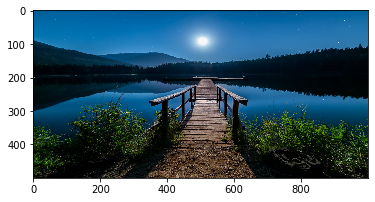

In [214]:
plt.imshow(dest)
matplotlib.image.imsave(filename.split('.')[0]+"_resized_"+str(height)+"x"+str(width)+"."+filename.split('.')[1], dest)
